In [1]:
import cv2
import mediapipe as mp
import imageio
import matplotlib.pyplot as plt
import numpy as np
from nanomesh import Mesher2D
from nanomesh import Image as nmImg
import numpy as np



I0000 00:00:1732551938.021256 2896403 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
/tmp/ipykernel_2896403/3368870390.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('right-hand-real.jpg')
I0000 00:00:1732551938.051721 2896534 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.154.05), renderer: Quadro RTX 8000/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732551938.085289 2896509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732551938.098877 2896505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback

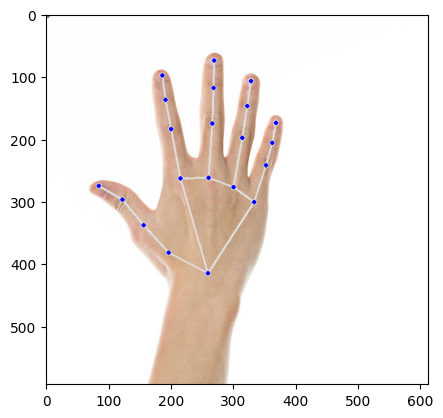

In [2]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

image = imageio.imread('right-hand-real.jpg')

# Process the frame
result = hands.process(image)

# Draw landmarks and extract fingertip positions
if result.multi_hand_landmarks:
    for hand_landmarks in result.multi_hand_landmarks:
        mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        # Fingertip landmarks (index 4, 8, 12, 16, 20)
        for idx in [4, 8, 12, 16, 20]:
            x = (hand_landmarks.landmark[idx].x)
            y = (hand_landmarks.landmark[idx].y)
            
            plt.imshow(image)
            plt.scatter(x, y, s=5)
            

plt.show()


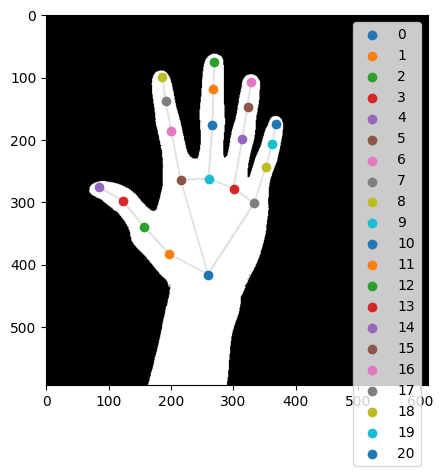

In [30]:
from einops import rearrange
# Step 1: Load the image and preprocess
image = cv2.imread("right-hand-real.jpg")  # Replace with your image
binary_image = image.sum(-1) / (255*3)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
mask = binary_image < (binary_image.max()*0.9)

mask_rgb = rearrange(np.array(np.vstack([mask, mask, mask])*255, dtype=np.uint8), '(c h) w -> h w c', c=3) 
cv2.imwrite('mask.png', mask_rgb)
mask = cv2.imread("mask.png")  # Replace with your image
h, w = mask.shape[0], mask.shape[1]

hand_vertices = []
for hand_landmarks in [result.multi_hand_landmarks[0]]:
    for idx in range(len(hand_landmarks.landmark)):
        x = (hand_landmarks.landmark[idx].x)
        y = (hand_landmarks.landmark[idx].y)
        plt.scatter(x*w, y*h, label=f'{idx}')
        hand_vertices.append((x, y))
    mp_draw.draw_landmarks(mask, hand_landmarks, mp_hands.HAND_CONNECTIONS)

hand_vertices = np.array(hand_vertices)
plt.imshow(mask)
plt.legend()


In [ ]:
# calculate finger direction and 6 7
direction = hand_vertices[6] - hand_vertices[7]
x, y = direction
normal1 = (-y, x)
normal2 = (-y, x)


KeyboardInterrupt: 

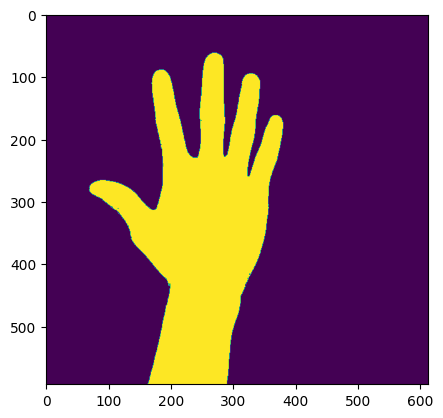

In [8]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import triangle as tr  # Install with `pip install triangle`
import matplotlib.pyplot as plt
from skimage import measure

def poisson_disk_sampling(mask, radius):
    """
    Generate points inside a mask using Poisson disk sampling.
    :param mask: Binary mask of the hand (255 for inside, 0 for outside).
    :param radius: Minimum distance between points.
    :return: List of points (x, y) inside the mask.
    """
    h, w = mask.shape
    points = []

    while len(points) < 500:  # Limit max points to avoid infinite loops
        x, y = np.random.randint(0, w), np.random.randint(0, h)
        if mask[y, x]:  # Ensure the point is inside the hand contour
            if all(np.linalg.norm(np.array([x, y]) - np.array(p)) > radius for p in points):
                points.append((x, y))

    return np.array(points)

def constrained_delaunay(contour, interior_points):
    """
    Perform constrained Delaunay triangulation on the hand.
    :param contour: Points forming the boundary of the hand.
    :param interior_points: Sampled interior points.
    :return: Triangulated mesh.
    """
    points = np.vstack([contour, interior_points])
    segments = [[i, (i + 1) % len(contour)] for i in range(len(contour))]

    # Triangle input
    t = {"vertices": points, "segments": segments}
    triangulated = tr.triangulate(t, 'p')  # 'p' ensures only constrained triangulation

    return triangulated

# Step 1: Load the image and preprocess
image = cv2.imread("right-hand-real.jpg")  # Replace with your image
binary_image = image.sum(-1) / (255*3)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# np.array()
mask = binary_image < (binary_image.max()*0.9)

plt.imshow(mask)
# mask = cv2.adaptiveThreshold(gray, 255 ,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 10, 2)

# Step 2: Find the hand contour
# contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# if contours:
# hand_contour = max(contours, key=cv2.contourArea).squeeze()
hand_contour = measure.find_contours(mask, level=0.5)

# Step 3: Sample interior points using Poisson disk sampling
radius = 10  # Minimum distance between points
interior_points = poisson_disk_sampling(mask, radius)

# Step 4: Perform constrained Delaunay triangulation
triangulated = constrained_delaunay(hand_contour, interior_points)

# Step 5: Visualize the mesh
mesh_image = image.copy()

# Draw triangles
for tri in triangulated["triangles"]:
    pts = triangulated["vertices"][tri].astype(int)
    cv2.polylines(mesh_image, [pts], isClosed=True, color=(0, 255, 0), thickness=1)

# Draw boundary
cv2.polylines(mesh_image, [hand_contour], isClosed=True, color=(255, 0, 0), thickness=2)

plt.imshow(mesh_image)


I0000 00:00:1732490765.244512 2888537 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732490765.271688 2888784 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.154.05), renderer: Quadro RTX 8000/PCIe/SSE2
W0000 00:00:1732490765.287832 2888754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732490765.303160 2888759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


<function matplotlib.pyplot.show(close=None, block=None)>

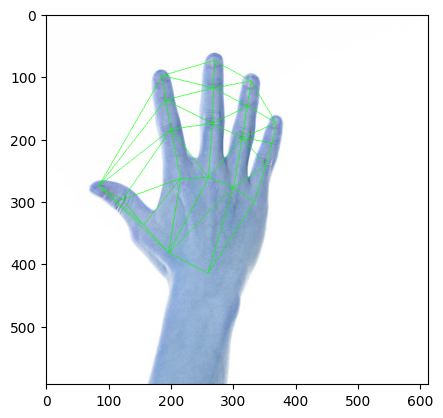

In [3]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import mediapipe as mp
import matplotlib.pyplot as plt

def draw_delaunay(img, points, triangles):
    """
    Draw the Delaunay triangulation on the image.
    """
    for triangle in triangles:
        pts = points[triangle]
        pts = pts.astype(np.int32)
        cv2.polylines(img, [pts], isClosed=True, color=(0, 255, 0), thickness=1)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# Load a hand image
image = cv2.imread("right-hand-real.jpg")  # Replace with your hand image file path
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process the image to find hand landmarks
result = hands.process(rgb_image)

if result.multi_hand_landmarks:
    for hand_landmarks in result.multi_hand_landmarks:
        # Extract 2D points of the hand landmarks
        landmarks = np.array([[lm.x * image.shape[1], lm.y * image.shape[0]] for lm in hand_landmarks.landmark])

        # Perform Delaunay triangulation
        delaunay = Delaunay(landmarks)
        triangles = delaunay.simplices

        # Draw the triangular mesh on the image
        mesh_image = image.copy()
        draw_delaunay(mesh_image, landmarks, triangles)

        # Visualize the result
        plt.imshow(mesh_image)

plt.show


In [ ]:
import cv2
import numpy as np
from scipy.spatial import Delaunay

def piecewise_affine_warp(source_points, target_points, image):
    """
    Perform piecewise affine warp.
    """
    triangles = Delaunay(source_points).simplices
    warped_image = np.zeros_like(image)

    for triangle in triangles:
        src_tri = np.float32(source_points[triangle])
        tgt_tri = np.float32(target_points[triangle])

        # Compute affine transform for the triangle
        matrix = cv2.getAffineTransform(src_tri, tgt_tri)

        # Mask for the triangle
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.fillConvexPoly(mask, tgt_tri.astype(int), (255, 255, 255))

        # Apply affine transformation
        warped_triangle = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
        warped_image = cv2.bitwise_or(warped_image, cv2.bitwise_and(warped_triangle, mask))

    return warped_image

# Example usage
image = cv2.imread('hand.jpg')  # Replace with your image

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

def calculate_rectangle(joint1, joint2, width):
    """
    Given two joints as the length of the rectangle and a width,
    calculate the rectangle's four corners.
    """
    # Vector from joint1 to joint2
    length_vector = np.array(joint2) - np.array(joint1)
    length = np.linalg.norm(length_vector)
    if length == 0:
        return None  # Avoid division by zero
    
    # Unit vector along the length
    unit_length_vector = length_vector / length
    
    # Perpendicular vector (rotated 90 degrees)
    perp_vector = np.array([-unit_length_vector[1], unit_length_vector[0]]) * width / 2
    
    # Calculate the corners of the rectangle
    p1 = joint1 + perp_vector
    p2 = joint1 - perp_vector
    p3 = joint2 - perp_vector
    p4 = joint2 + perp_vector
    
    return np.array([p1, p2, p3, p4], dtype=np.int32)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils


# Convert the frame to RGB
image = imageio.imread('right-hand-real.jpg')

# Process the frame with MediaPipe Hands
result = hands.process(image)

if result.multi_hand_landmarks:
    for hand_landmarks in result.multi_hand_landmarks:
        # Extract landmark coordinates
        landmarks = [(int(lm.x * image.shape[1]), int(lm.y * image.shape[0])) for lm in hand_landmarks.landmark]

        # Example: Iterate over fingers
        for finger_idx in range(5):  # 5 fingers
            # MCP, PIP, DIP, TIP indices for each finger
            mcp_idx = 5 + finger_idx * 4
            pip_idx = mcp_idx + 1
            dip_idx = pip_idx + 1
            tip_idx = dip_idx + 1

            # Example: Width as average distance between MCP and PIP
            if mcp_idx < len(landmarks) and pip_idx < len(landmarks):
                joint1 = landmarks[mcp_idx]
                joint2 = landmarks[pip_idx]
                width = np.linalg.norm(np.array(joint1) - np.array(joint2)) * 0.5

                # Calculate the rectangle
                rectangle = calculate_rectangle(joint1, joint2, width)
                if rectangle is not None:
                    # Draw the rectangle
                    cv2.polylines(image, [rectangle], isClosed=True, color=(0, 255, 0), thickness=2)

cv2.imshow()

